In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
from random import shuffle
import warnings
import seaborn as sns
warnings.simplefilter(action='ignore', category=FutureWarning)

# Exploring the Data

In [2]:
img_p = 'data/paper/paper (148).png'
img_r = 'data/rock/rock (148).png'
img_s = 'data/scissors/scissors (130).png'

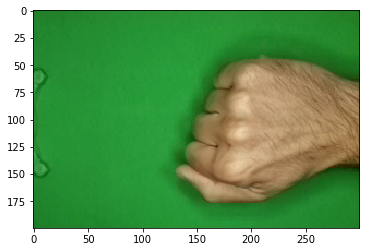

In [3]:
img_rgb = cv2.imread(img_r)
img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

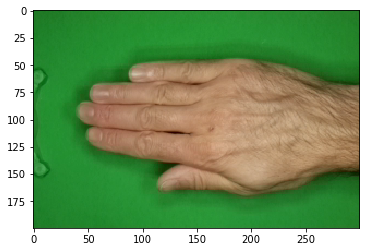

In [4]:
img_rgb = cv2.imread(img_p)
img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

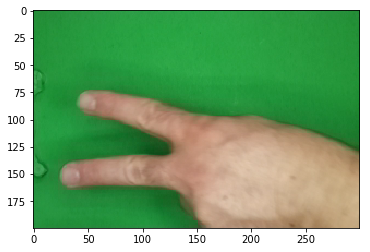

In [5]:
img_rgb = cv2.imread(img_s)
img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

# Data Pre-processing

In [6]:
img_size = 70

In [19]:
def image_preprocessor(path, label):
    
    temp_list = []
    error_count = 0
    
    for i in tqdm(os.listdir(path)):
        try:
            img = cv2.imread(path+'/'+i)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (img_size,img_size))
            img = img/255
            label = np.array(label)
            temp_list.append((img, label))
        except:
            error_count += 1
            
    print('Image Error with Format: {}'.format(error_count))
    return temp_list

In [20]:
data_p = './data/paper'
data_s = './data/scissors'
data_r = './data/rock'

In [21]:
img_r = image_preprocessor(data_r, 0)
img_p = image_preprocessor(data_p, 1)
img_s = image_preprocessor(data_s, 2)

  9%|███████▏                                                                        | 64/714 [00:00<00:01, 567.43it/s]

Image Error with Format: 0


  7%|█████▉                                                                          | 56/750 [00:00<00:01, 555.29it/s]

Image Error with Format: 2


100%|███████████████████████████████████████████████████████████████████████████████| 750/750 [00:01<00:00, 523.32it/s]

Image Error with Format: 0


# Model Preparation

In [22]:
from sklearn.model_selection import train_test_split
import random

total_data = img_r+img_p+img_s
random.shuffle(total_data)

X = [i[0] for i in total_data]
X = np.array(X)
X = np.reshape(X, (-1,img_size, img_size,1))

y = [i[1] for i in total_data]
y = np.array(y)
y = np.reshape(y, (-1,1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=101)

# Training Models

In [7]:
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, LSTM, Flatten, Reshape, Permute, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, load_model

In [8]:
model_checkpoint_callback = ModelCheckpoint(filepath='best_model.h5', save_weights_only=True,
                                            monitor='val_acc', mode='max', save_best_only=True,verbose=1)

model_earlystopping_callback = EarlyStopping(monitor='val_loss', patience=3)

model_plateau_callback = ReduceLROnPlateau(monitor='val_loss', patience=2)

callback_list = [model_checkpoint_callback, model_earlystopping_callback, model_plateau_callback]

In [9]:
model = Sequential()

model.add(Conv2D(64,(3,3), activation='relu', input_shape=(img_size, img_size,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(5,5)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(256,(5,5)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

#model.load_weights('best_model.h5')

In [28]:
model.fit(x=X_train, y=y_train, callbacks=callback_list, batch_size=32, epochs=30, validation_split=0.15)

Train on 1673 samples, validate on 296 samples
Epoch 1/30
1673/1673 [==============================] - 134s 80ms/step - loss: 0.5227 - acc: 0.8171 - val_loss: 5.6695 - val_acc: 0.2973

Epoch 00001: val_acc improved from -inf to 0.29730, saving model to best_model.h5
Epoch 2/30
1673/1673 [==============================] - 127s 76ms/step - loss: 0.2251 - acc: 0.9372 - val_loss: 7.0265 - val_acc: 0.2973

Epoch 00002: val_acc did not improve from 0.29730
Epoch 3/30
1673/1673 [==============================] - 127s 76ms/step - loss: 0.1867 - acc: 0.9432 - val_loss: 9.5258 - val_acc: 0.2973

Epoch 00003: val_acc did not improve from 0.29730
Epoch 4/30
1673/1673 [==============================] - 127s 76ms/step - loss: 0.1326 - acc: 0.9564 - val_loss: 3.7130 - val_acc: 0.2973

Epoch 00004: val_acc did not improve from 0.29730
Epoch 5/30
1673/1673 [==============================] - 127s 76ms/step - loss: 0.1162 - acc: 0.9677 - val_loss: 2.5024 - val_acc: 0.2973

Epoch 00005: val_acc did not im

# Model Evaluation

In [29]:
df_model = pd.DataFrame(model.history.history)

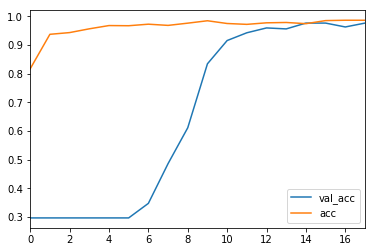

In [30]:
df_model[['val_acc','acc']].plot()

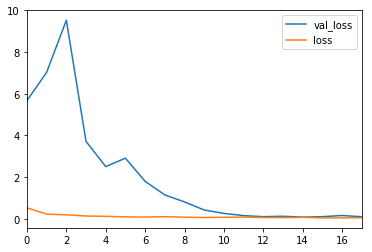

In [31]:
df_model[['val_loss','loss']].plot()

In [32]:
from tensorflow.keras.models import load_model

#model = load_model('best_model.h5')
predictions = model.predict_classes(X_test)

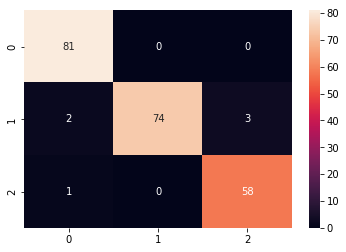

In [33]:
from sklearn.metrics import confusion_matrix, classification_report

cf_matrix = confusion_matrix(y_test, predictions)
sns.heatmap(cf_matrix, annot=True, fmt='g')

In [35]:
print(classification_report(y_test, predictions))

             precision    recall  f1-score   support

          0       0.96      1.00      0.98        81
          1       1.00      0.94      0.97        79
          2       0.95      0.98      0.97        59

avg / total       0.97      0.97      0.97       219



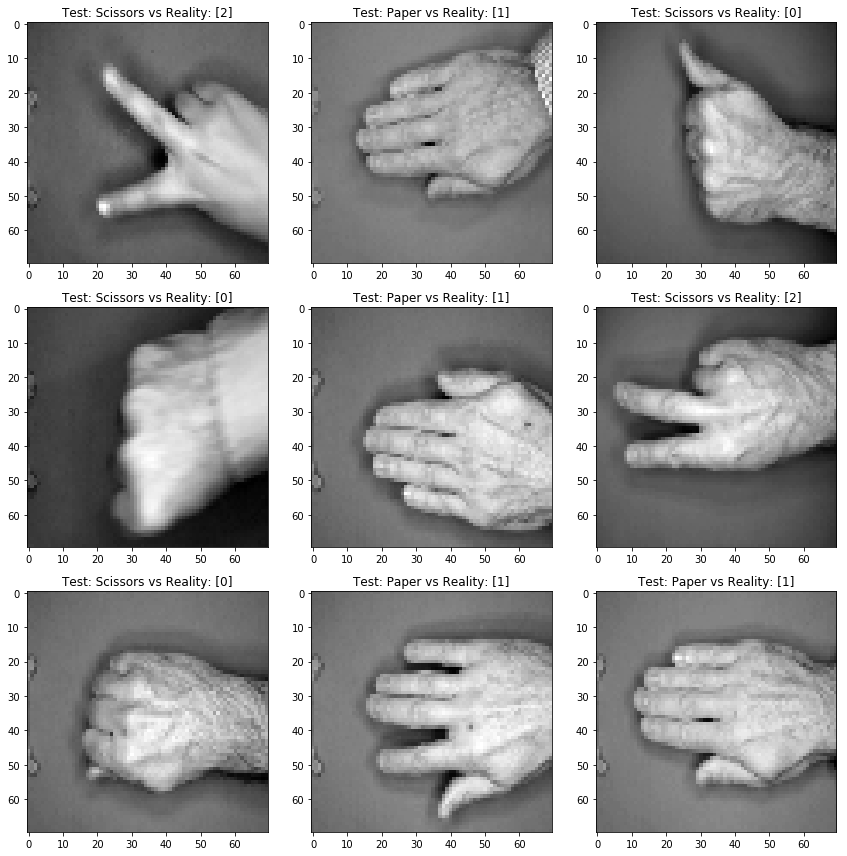

In [44]:
width=8
height=8
rows = 3
cols = 3
axes=[]
fig=plt.figure(figsize=(12,12))

for a in range(rows*cols):
    b = np.reshape(X_test[a], (img_size,img_size))
    axes.append(fig.add_subplot(rows, cols, a+1))
    if predictions[a] == 0:
        subplot_title=('Test: Rock vs Reality: {}'.format(y_test[a]))
    if predictions[a] == 1:
        subplot_title=('Test: Paper vs Reality: {}'.format(y_test[a]))
    else:
        subplot_title=('Test: Scissors vs Reality: {}'.format(y_test[a]))
    axes[-1].set_title(subplot_title)  
    
    plt.imshow(b, cmap='gray')
fig.tight_layout()    
plt.show()

# 0: Rock, 1: Paper, 2: Scissors

# Predictions on Real Time

In [10]:
import cv2

img_list = [] 
cap = cv2.VideoCapture(0)

width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
font = cv2.FONT_HERSHEY_SIMPLEX
last_pred = [0]

while True:
    
    # Capture frame-by-frame
    ret, frame = cap.read()
    
    # Our operations on the frame come here
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (img_size,img_size))
    img = img/255
    img = np.reshape(img, (-1,img_size,img_size,1))
    live_pred = model.predict_classes(img)
    
    if live_pred[0] == 0: text_pred = 'Rock'
    if live_pred[0] == 1: text_pred = 'Paper'
    if live_pred[0] == 2: text_pred = 'Scissors'
         
        
    # Display the resulting frame
    cv2.putText(gray, text_pred, (230, 160), cv2.FONT_HERSHEY_PLAIN, 3, (0, 255, 0))
    cv2.imshow('frame',gray)
    
    # This command let's us quit with the "q" button on a keyboard.
    # Simply pressing X on the window won't work!
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    img_list.append(frame)

# When everything done, release the capture and destroy the windows
cap.release()
cv2.destroyAllWindows()